In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# Any results you write to the current directory are saved as output.

In [2]:
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils
from keras.utils.vis_utils import plot_model

2022-11-12 16:01:43.581848: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-12 16:01:43.760799: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-12 16:01:43.767113: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-12 16:01:43.767130: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [3]:
df = pd.read_csv('./fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [5]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [6]:
df.emotion

0        0
1        0
2        2
3        4
4        6
        ..
35882    6
35883    3
35884    0
35885    3
35886    2
Name: emotion, Length: 35887, dtype: int64

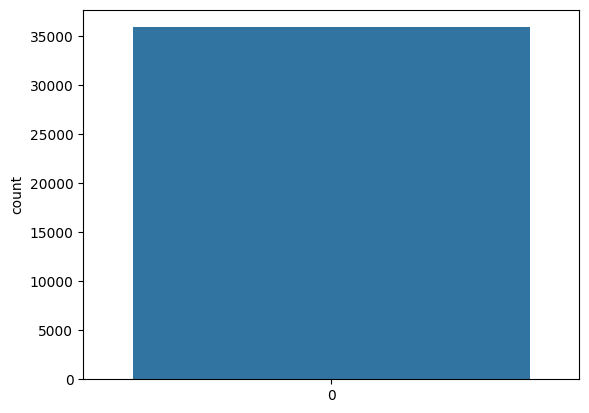

In [7]:
sns.countplot(df.emotion)
pyplot.show()

`So majority classes belongs to 3:Happy, 4:Sad and 6:Neutral nd we are also intersted in these three classes only.`

In [8]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

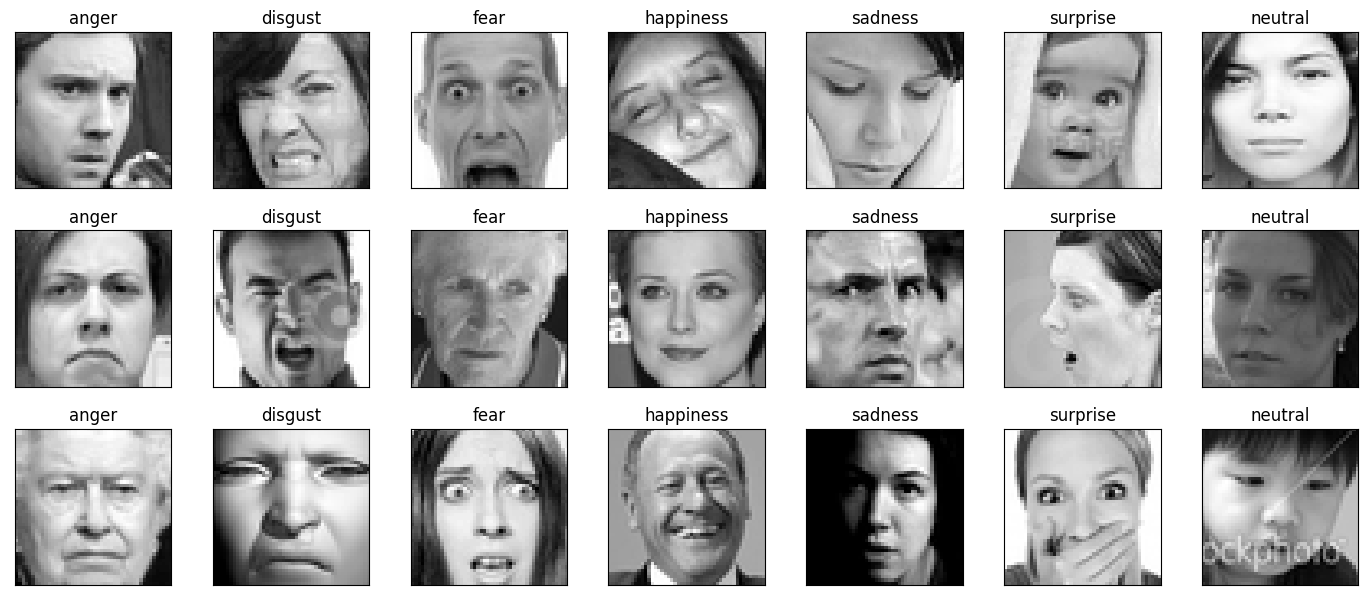

In [9]:
fig = pyplot.figure(1, (14, 14))

k = 0
for j in range(3):
    for label in sorted(df.emotion.unique()):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [10]:
INTERESTED_LABELS = [3, 4, 6]
# INTERESTED_LABELS = [0, 1, 2, 3, 4, 5, 6]

In [11]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(21264, 3)

`Now I will make the data compatible for neural networks.`

In [12]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [13]:
img_array.shape

(21264, 48, 48, 1)

In [14]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(21264, 3)

In [15]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{3: 0, 4: 1, 6: 2}


`Splitting the data into training and validation set.`

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((19137, 48, 48, 1), (2127, 48, 48, 1), (19137, 3), (2127, 3))

In [17]:
del df
del img_array
del img_labels

In [18]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [19]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [20]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [21]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [22]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [23]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
# model = build_net(optims[1]) 
# history = model.fit_generator(
#     train_datagen.flow(X_train, y_train, batch_size=batch_size),
#     validation_data=(X_valid, y_valid),
#     steps_per_epoch=len(X_train) / batch_size,
#     epochs=epochs,
#     callbacks=callbacks,
#     use_multiprocessing=True
# )

In [24]:
# with open("model.json", "r") as yaml_file:
#     yaml_file.write(model_json)
# model_json = model.to_json()
    
# model.save("model.h5")
model = keras.models.load_model('model.h6')

2022-11-12 16:02:11.266609: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-12 16:02:11.266648: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-12 16:02:11.266672: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DITO-156): /proc/driver/nvidia/version does not exist
2022-11-12 16:02:11.267200: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
# sns.set()
# fig = pyplot.figure(0, (12, 4))

# ax = pyplot.subplot(1, 2, 1)
# sns.lineplot(history.history['accuracy'], label='train')
# sns.lineplot(history.history['val_accuracy'], label='valid')
# pyplot.title('Accuracy')
# pyplot.tight_layout()

# ax = pyplot.subplot(1, 2, 2)
# sns.lineplot(history.history['loss'], label='train')
# sns.lineplot(history.history['val_loss'], label='valid')
# pyplot.title('Loss')
# pyplot.tight_layout()

# pyplot.savefig('epoch_history_dcnn.png')
# pyplot.show()

    The epochs history shows that accuracy gradually increases and achieved +83% accuracy on both training and validation set, but at the end the model starts overfitting training data.

In [26]:
# df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
# df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

# fig = pyplot.figure(0, (14, 4))
# ax = pyplot.subplot(1, 2, 1)
# sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
# pyplot.title('Accuracy')
# pyplot.tight_layout()

# ax = pyplot.subplot(1, 2, 2)
# sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
# pyplot.title('Loss')
# pyplot.tight_layout()

# pyplot.savefig('performance_dist.png')
# pyplot.show()

In [27]:
yhat_valid=np.argmax(model.predict(X_valid), axis=1)

# scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
# pyplot.savefig("confusion_matrix_dcnn.png")
print(precision_score(np.argmax(y_valid, axis=1), yhat_valid, labels=[4], average='micro'))
print(recall_score(np.argmax(y_valid, axis=1), yhat_valid, labels=[4], average='micro'))
print(f1_score(np.argmax(y_valid, axis=1), yhat_valid, labels=[4], average='micro'))

# print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
# clf_report = {
#     'Raiva': {
#         'precision': 0.6438356164383562, 
#         'recall': 0.6646464646464646, 
#         'f1-score': 0.6540755467196819, 
#         'support': 495
#     }, 
#     'Desgosto': {
#         'precision': 0.7857142857142857, 
#         'recall': 0.6, 
#         'f1-score': 0.6804123711340206, 
#         'support': 55
#     }, 
#     'Medo': {
#         'precision': 0.6235294117647059, 
#         'recall': 0.4140625, 
#         'f1-score': 0.49765258215962443, 
#         'support': 512
#     }, 
#     'Felicidade': {
#         'precision': 0.8998862343572241, 
#         'recall': 0.8798665183537263, 
#         'f1-score': 0.8897637795275591, 
#         'support': 899
#     }, 
#     'Tristeza': {
#         'precision': 0.6075471698113207, 
#         'recall': 0.5296052631578947, 
#         'f1-score': 0.5659050966608083, 
#         'support': 608
#     }, 
#     'Surpresa': {
#         'precision': 0.7613365155131265, 
#         'recall': 0.7975, 
#         'f1-score': 0.778998778998779, 
#         'support': 400
#     }, 
#     'Neutralidade': {
#         'precision': 0.5829493087557603, 
#         'recall': 0.8161290322580645, 
#         'f1-score': 0.6801075268817204, 
#         'support': 620
#     }, 
#     'accuracy': 0.6999164112566174, 
#     'macro avg': {
#         'precision': 0.7006855060506829, 
#         'recall': 0.6716871112023072, 
#         'f1-score': 0.6781308117260277, 
#         'support': 3589
#     }, 
#     'weighted avg': {
#         'precision': 0.7036805673561024, 
#         'recall': 0.6999164112566174, 
#         'f1-score': 0.6946844003721278, 
#         'support': 3589
#     }
# }

clf_report = classification_report(np.argmax(y_valid, axis=1), yhat_valid, output_dict=True)


print(clf_report)
# sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="crest")

67/67 [==============================] - 17s 243ms/step
0.0
0.0
0.0
{'0': {'precision': 0.9382857142857143, 'recall': 0.9132369299221357, 'f1-score': 0.9255918827508456, 'support': 899}, '1': {'precision': 0.8055045871559633, 'recall': 0.7220394736842105, 'f1-score': 0.7614917606244579, 'support': 608}, '2': {'precision': 0.7086280056577087, 'recall': 0.8080645161290323, 'f1-score': 0.7550866616428034, 'support': 620}, 'accuracy': 0.8279266572637518, 'macro avg': {'precision': 0.8174727690331287, 'recall': 0.8144469732451262, 'f1-score': 0.8140567683393689, 'support': 2127}, 'weighted avg': {'precision': 0.8333874046269215, 'recall': 0.8279266572637518, 'f1-score': 0.8289834618106341, 'support': 2127}}


/home/matheus.quintao/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matheus.quintao/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matheus.quintao/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


The confusion matrix clearly shows that our model is doing good job on the class `happy` but it's performance is low on other two classes. One of the reason for this could be the fact that these two classes have less data. But when I looked at the images I found some images from these two classes are even hard for a human to tell whether the person is sad or neutral. Facial expression depends on individual as well. Some person's neutral face looks like sad.

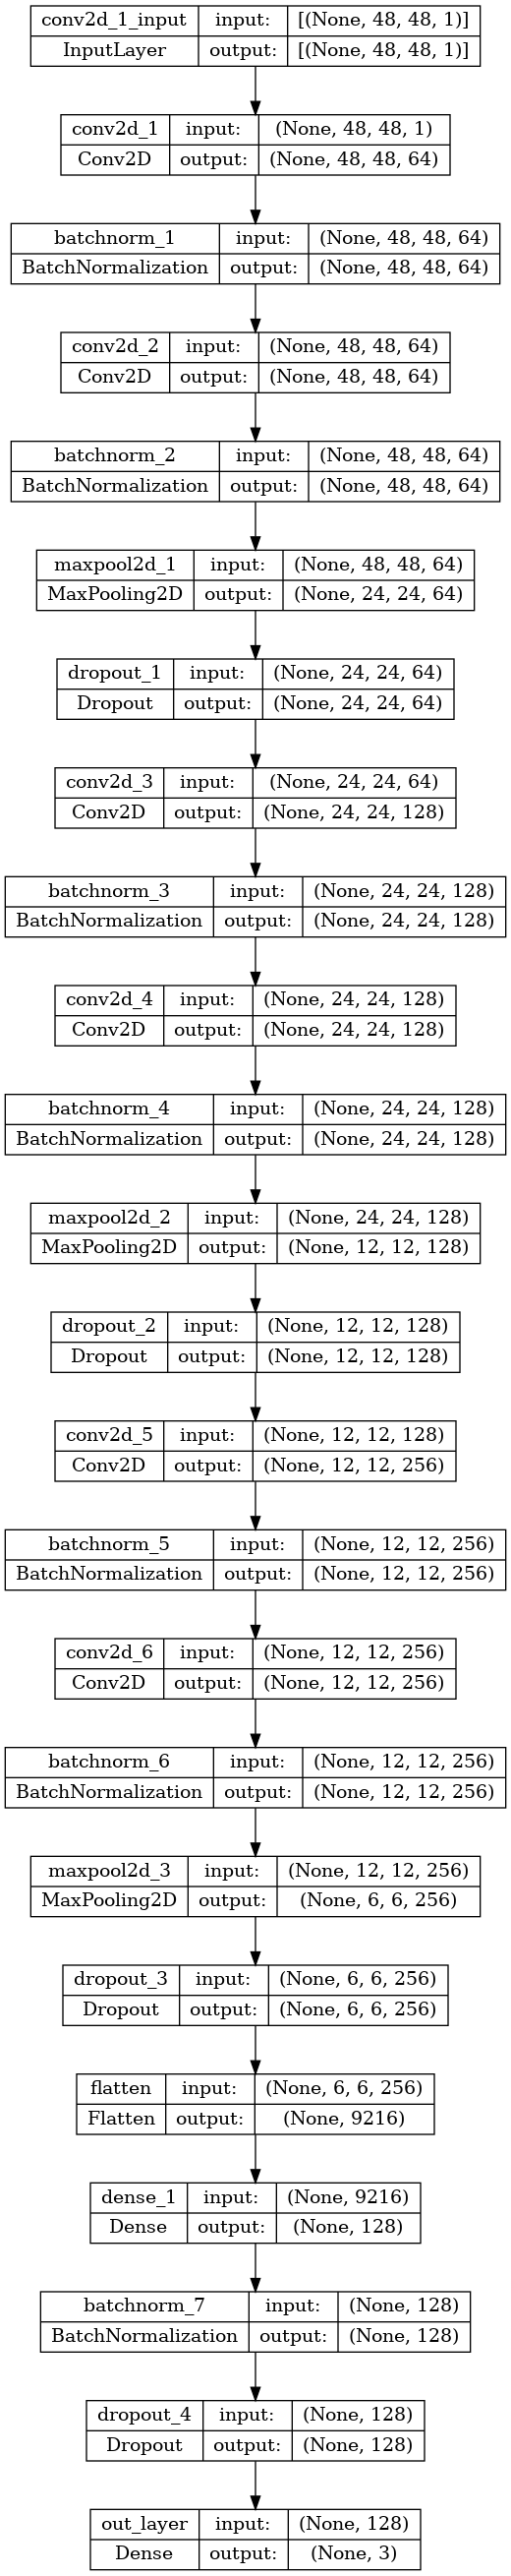

In [28]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [29]:
mapper = {
    0: "happy",
    1: "sad",
    2: "neutral",
}

1/1 [==============================] - 0s 32ms/step


/tmp/ipykernel_252948/2418829227.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = pyplot.subplot(2, 9, i+1)
/tmp/ipykernel_252948/2418829227.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = pyplot.subplot(2, 9, i+10)


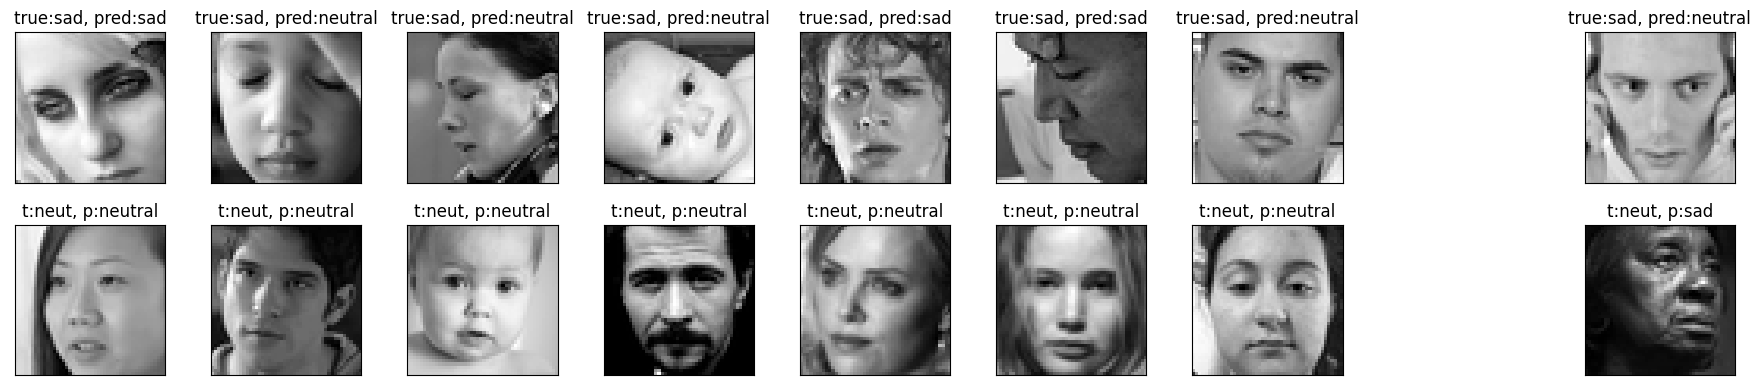

In [30]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:sad, pred:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1)), axis=1)[0]]}")

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:neut, p:{mapper[np.argmax(model.predict(sample_img.reshape(1,48,48,1)), axis=1)[0]]}")

        pyplot.tight_layout()

See in the first row 7th image looks more like neutral rather than sad and our model even predicted it neutral. Whereas the last image in second row is very much sad.